# Laboratorio Vision Transformer parte 1

## Introducción

En este laboratorio implementaremos un modelo de  [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929)
propuesto por  Alexey Dosovitskiy et al. para la clasificación de imágenes. Lo construiremos desde 0 y lo entrenaremos en la base de datos CIFAR-10 para resolver la tarea de clasificación. Veremos la complejidad computacional que representa entrenar uno de estos modelos y comprenderemos la importancia de utilizar modelos pre-entrenados. 


## Librerias

In [1]:
#Importamos las librerias necesarias
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import ssl
ssl._create_default_https_context = ssl._create_unverified_context


## 1.0 Base de datos CIFAR10

El conjunto de datos CIFAR-10 es una colección de imágenes utilizado ampliamente para entrenar algoritmos de aprendizaje automático y visión por computadora. Se compone de 60,000 imágenes a color de 32x32 píxeles, distribuidas en 10 clases diferentes, cada una con 6,000 imágenes. Las clases incluyen avión, automóvil, ave, gato, venado, perro, rana, caballo, barco y camión.

Este conjunto de datos es crucial en la investigación y desarrollo de algoritmos de reconocimiento de objetos en fotos. A diferencia de MNIST, que se centra en dígitos escritos a mano, CIFAR-10 presenta imágenes más desafiantes debido a su naturaleza a color y la diversidad de objetos representados.

Recopilado por Alex Krizhevsky, Vinod Nair y Geoffrey Hinton, CIFAR-10 ofrece un conjunto de imágenes que permite a los investigadores probar y mejorar diferentes algoritmos de manera eficiente. Las 10 clases son mutuamente excluyentes, lo que significa que una imagen no puede pertenecer a más de una clase. Este conjunto de datos ha sido fundamental en el desarrollo y evaluación de modelos de redes neuronales convolucionales, que han demostrado ser particularmente efectivos para reconocer las imágenes de CIFAR-10.

Para más información sobre esta base de datos y sus variantes, dirijase a [base de datos CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html).

## 1.1 Pre-procesamiento de los datos

In [2]:
#Tenemos 10 clases en nuestra base de datos
num_classes = 10
#Dimensiones de nuestras imágenes
input_shape = (32, 32, 3)
#Cargamos la base de datos CIFAR10
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()


#Usaremos únicamente el 50% de la base de datos
train_size = 0.5
test_size = 0.5

# Tomamos solo el 50% de los datos
x_train, _, y_train, _ = train_test_split(x_train, y_train, train_size=train_size, stratify=y_train)
x_test, _, y_test, _ = train_test_split(x_test, y_test, test_size=test_size, stratify=y_test)

#Vemos la forma de nuestros datos
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")




170498071/170498071 [==============================] - 3s 0us/step
x_train shape: (25000, 32, 32, 3) - y_train shape: (25000, 1)
x_test shape: (5000, 32, 32, 3) - y_test shape: (5000, 1)


## 2.0 Configuración de los hiperparámetros del modelo

Ahora procederemos a especificar algunos de los hiperparámetros más cruciales para el entrenamiento de nuestro Vision Transformer (ViT). En primer lugar, definiremos la tasa de aprendizaje (learning rate) para el optimizador durante el algoritmo de descenso de gradiente, así como el parámetro de weight_decay. Este último, en términos informales, actúa como un parámetro de regularización. Básicamente, contribuye a gestionar el overfitting en nuestro modelo, penalizando en la función de pérdida la complejidad de este. Esta penalización nos permite trabajar con modelos que posean numerosos parámetros sin volverse excesivamente complejos y, por ende, evita que el modelo se ajuste demasiado a los datos de entrenamiento, permitiéndole generalizar de manera efectiva a datos no vistos anteriormente.

Además, abordaremos la definición del batch_size. Este parámetro nos proporciona el control sobre la cantidad de datos que el modelo analiza antes de actualizar sus parámetros durante la retropropagación y el descenso del gradiente. Por cuestiones de limitaciones de memoria, debemos ser cautelosos al seleccionar un batch size, evitando que sea demasiado grande y, por ende, consuma excesiva memoria al almacenar numerosas imágenes en la memoria.

Dado que nos enfrentamos a restricciones computacionales, optaremos por entrenar durante una sola época. Asimismo, determinaremos en cuántos 'patches' subdividiremos nuestras imágenes de entrenamiento, recordando que en un Vision Transformer es necesario dividir las imágenes en fragmentos más pequeños o 'patches' antes de introducirlos al modelo.

Finalmente, abordaremos algunos hiperparámetros específicos de la arquitectura de nuestro Vision Transformer. Esto incluirá la cantidad de cabezas de autoatención, el número de capas del transformer y, por último, el tamaño de las capas densas dentro del encoder.

Para más información sobre cada uno de estos hiperparámetros visite la [documentación de Keras](https://keras.io/examples/vision/image_classification_with_vision_transformer/).

In [3]:
#Definimos los hiperparámetros más importantes para la arquitectura del transformer y para su entrenamiento
learning_rate = 0.001 #Definimos la tasa de aprendizaje del optimizador
weight_decay = 0.0001 #Definimos la regularización weight decay en la función de pérdida
batch_size = 32 #Definimos el tamaño de los batches
num_epochs = 5 #Definimos el número de épocas de entrenamiento
image_size = 72  # Convertimos la imágenes de entrada a este tamaño
patch_size = 6  # Tamaño de los patches de entrada de las imágenes
num_patches = (image_size // patch_size) ** 2
projection_dim = 64 #Dimensión de la prpyección lineal de los patches
num_heads = 4 #Número de cabezas de atención
transformer_units = [
    projection_dim * 2,
    projection_dim,]  
transformer_layers = 8# Tamaño de las capas de transformer
mlp_head_units = [2048, 1024]  # Tamaño de las capas densas del clasificador


## Data augmentation

Data augmentation o aumento de datos es una técnica fundamental en el aprendizaje profundo, especialmente para tareas como la clasificación de imágenes. Consiste en expandir artificialmente el conjunto de entrenamiento mediante la creación de versiones modificadas de los datos existentes, ya sea a través de alteraciones menores o generando nuevos datos utilizando técnicas de aprendizaje profundo. Por ejemplo, en la aumentación de imágenes se aplican transformaciones geométricas y de espacio de color, como rotaciones, cambios de tamaño y ajustes de brillo, para mejorar el tamaño y la diversidad del conjunto de entrenamiento. La aumentación de datos es esencial para prevenir el sobreajuste de los modelos, especialmente cuando el conjunto de entrenamiento inicial es limitado, y ayuda a mejorar la precisión del modelo. Además, contribuye a reducir el costo operativo de etiquetar y limpiar conjuntos de datos crudos. 

Emplearemos diversas funciones proporcionadas por Keras, tales como RandomFlip, RandomRotation, Resizing y RandomZoom, para llevar a cabo la aumentación de datos. De esta manera, a través de rotaciones, ajustes de tamaño, zoom, entre otros, generaremos datos sintéticos con el objetivo de ampliar la cantidad de muestras en nuestra base de datos. 

In [4]:
#Definimos una función que normaliza todos los datos y les aplica técnicas de data augmentation. 
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),#Normaliza la imagen
        layers.Resizing(image_size, image_size),#Cambia el tamaño de la imagen
        layers.RandomFlip("horizontal"),#Aplica un giro aleatorio
        layers.RandomRotation(factor=0.02),#Aplica una rotación aleatoria
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2 #Aplica un zoom aleatorio
        ),
    ],
    name="data_augmentation",
)
# Calculamos la media y la varianza de los datos de entrenamiento para la normalización
data_augmentation.layers[0].adapt(x_train)


## 3.0 Creación del modelo

### 3.1 Implementación del multilayer perceptron (MLP) y dropout

En esta celda crearemos un multilayer perceptron. Esto no es más que los bloques de redes neuronales que hay dentro del bloque de encoder del Vision Transformer. Utilizamos dos parámetros: hidden_units y droput_rate. Hidden units simplemente indica qué tantas capas queremos que tenga nuestra red y Droput rate es un hiperparámetro que nos ayuda a solucionar e problema de overfitting o sobreajuste apagando aleatoriamente un porcentaje de neuronas durante el entrenamiento. En otras palabras, durante cada iteración de entrenamiento, se "apaga" un conjunto aleatorio de neuronas, lo que significa que no contribuirán a la propagación hacia adelante ni a la retropropagación. Esta es una técnica eficaz para mejorar la generalización de las redes neuronales al evitar que los nodos dependan demasiado unos de otros durante el entrenamiento y el hiperparámetro dropout_rate nos indica precisamente con qué probabilidad se van a apagar las neuronas. 

En esta red utilizaremos la función de activción no lineal [GELU](https://keras.io/api/layers/activations/#gelu-function) o Gaussian Rectified Linear Unit. 

In [5]:
#Creamos un multilayer perceptron
def mlp(x, hidden_units, dropout_rate):
    #Lo creamos de la profundidad deseada, con función de activación gelu y regularización por dropout
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


### 3.2 Creamos la capa que genera los patches

Ya definimos la arquitectura del MLP en la celda anterior, ahora definiremos un bloque que toma una imágen y la subdivide en varios patches para que luego sean procesados por el ViT. Esto lo podemos ver en la siguiente figura. 

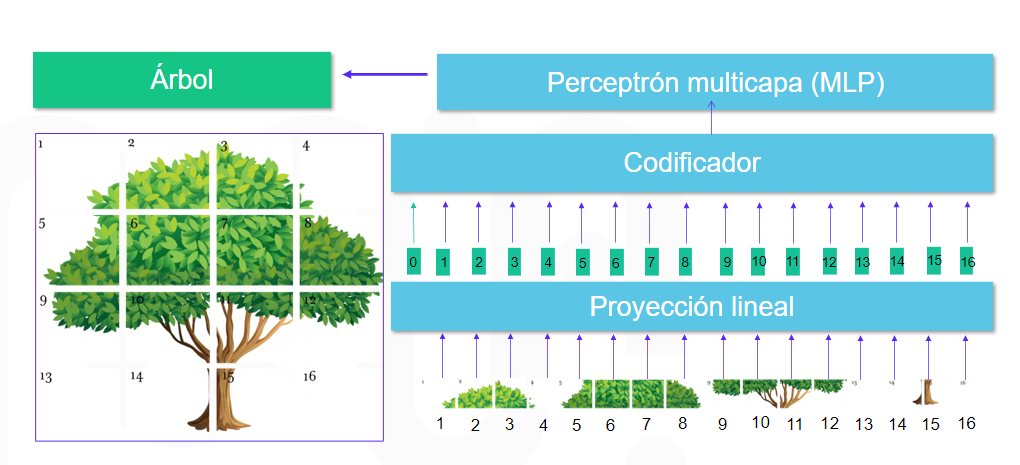

In [6]:
# Definimos una capa que divide una imagen en parches (patches)
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        # Obtenemos el tamaño del lote (batch size) de las imágenes
        batch_size = tf.shape(images)[0]
        
        # Extraemos los parches de las imágenes utilizando la función extract_patches de TensorFlow
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        
        # Obtenemos las dimensiones de los parches y los remodelamos para tener una forma consistente
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        
        # Devolvemos los parches
        return patches

En la siguiente celda podemos visualizar qué le hace la función Patches() a una imagen de nuestra base de datos. 

Tamaño de la imagen: 72 X 72
Tamaño del parche: 6 X 6


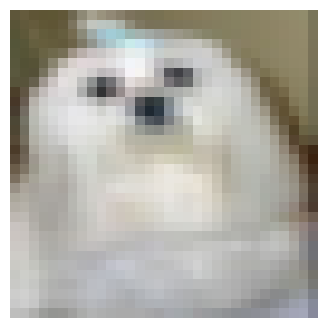

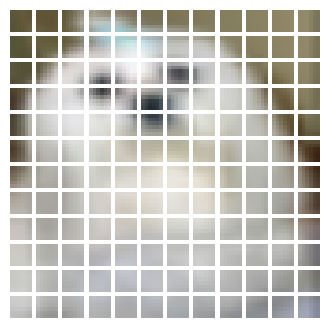

In [10]:
# Visualización de una imagen de entrenamiento y sus parches resultantes
plt.figure(figsize=(4, 4))
# Seleccionamos una imagen aleatoria del conjunto de entrenamiento
image = x_train[np.random.choice(range(x_train.shape[0]))]
# Mostramos la imagen original
plt.imshow(image.astype("uint8"))
plt.axis("off")

# Redimensionamos la imagen a un tamaño específico y obtenemos sus parches
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
# Utilizamos la capa Patches para dividir la imagen en parches
patches = Patches(patch_size)(resized_image)
print(f"Tamaño de la imagen: {image_size} X {image_size}")
print(f"Tamaño del parche: {patch_size} X {patch_size}")

# Visualización de los parches generados a partir de la imagen
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    # Remodelamos cada parche y lo mostramos
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")
plt.show()


### 3.3 Implementamos la capa de patch-encoding


Ahora, al igual que en el transforer de lenguaje vamos a definir el bloque de codificación. En los transformers de lenguaje estudiamos los positional embeddings o codificación posicional. En esta celda definiremos una capa personalizada en TensorFlow llamada PatchEncoder. La función principal de esta capa es codificar información sobre la posición de parches en una imagen, algo comúnmente utilizado en arquitecturas de transformers para visión (ViT).

In [11]:
# Definimos la clase PatchEncoder para codificar la información posicional de los parches en la imagen
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        # Generamos posiciones para los parches en la imagen
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        # Codificamos la información posicional combinando proyección y embedding de posición
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


### 4.0 Construyendo el modelo ViT, uniendo todos los bloques

Ahora, uniremos todos los bloques que definimos anteriormente para crear nuestra arquitectura de ViT.

Nuestra arquitectura de Vision Transformer está compuesta por varios bloques. Cada bloque  consta de tres elementos clave: primero, una capa de normalización por batches y atención multi-cabeza, que permite al modelo capturar relaciones globales entre los parches de la imagen; segundo, una conexión residual que preserva la información original en cada bloque; y tercero, una capa de perceptrón multicapa (MLP) que procesa la información localmente. 

Estos bloques se replican múltiples veces, lo que permite al modelo aprender patrones complejos en diferentes niveles de abstracción simultáneamente. La salida final de cada bloque se normaliza por batches, se aplana y se conecta a un MLP adicional antes de la capa de salida de clasificación.

Además, como vimos anteriormente el modelo utiliza técnicas como la regularización mediante dropout para mejorar la generalización y estabilidad durante el entrenamiento en batches de datos.

In [13]:

def create_vit_classifier():
    #Creamos la capa de entrada
    inputs = layers.Input(shape=input_shape)
    # Hacemos data augmentation
    augmented = data_augmentation(inputs)
    # Creamos los patches
    patches = Patches(patch_size)(augmented)
    # Codificadmos los patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Creamos multiples capas de bloques transformer
    for _ in range(transformer_layers):
        # Normalización por capas 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Creamos una capa de atención multi-cabeza.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Conexión residual 1
        x2 = layers.Add()([attention_output, encoded_patches])
        # Normalización por capas 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Conexión residual 2
        encoded_patches = layers.Add()([x3, x2])

    # Creamos un ternsor [batch_size, projection_dim].
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Añadimos un MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Clasificamos las salidas
    logits = layers.Dense(num_classes)(features)
    # Creamos el modelo
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## 5.0 Compilar, entrenar y evaluar el modelo.

Ahora entrenameremos nuestro Vision Transformer (ViT). Utilizaremos un optimizador conocido como [AdamW](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/AdamW). Este optimizador utiliza una versión modificada del algoritmo de descenso del gradiente estocástico que hemos utilizado en otros laboratorios.

Utilizaremos la función de pérdida [de entropía cruzada categórica dispersa](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/SparseCategoricalCrossentropy), esta es una versión de la cross entropia que hemos estudiado durante el curso. También utilizaremos la métrica de [precisión categórica dispersa](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/SparseCategoricalAccuracy), esta es una métrica similar a la precisión que hemos visto en los otros laboratorios pero que se ha modificado a problemas donde tenemos varias clases. 

Luego, guardaremos los pesos del modelo en el punto donde se alcanza la mejor precisión en el conjunto de validación. Al finalizar el entrenamiento, evaluamos el modelo en un conjunto de prueba  y se registramos las métricas de precisión. La práctica de guardar los pesos en el punto óptimo durante la validación asegura que se conserve la mejor versión del modelo. Tanto el modelo entrenado como el historial de entrenamiento se devuelven como resultado de este proceso de entrenamiento para poder evaluar qué tan bueno fue el entrenamiento de nuestro modelo. 

In [14]:
def run_experiment(model):
    # Configuramos el optimizador AdamW con la tasa de aprendizaje y la decaimiento de peso proporcionados.
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    # Compilamos el modelo con el optimizador, la función de pérdida y las métricas que queremos monitorear.
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        ],
    )

    # Establecemos la ruta y configuración para guardar los pesos del modelo durante el entrenamiento.
    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    # Entrenamos el modelo con los datos de entrenamiento, con validación del 10%, y guardamos los pesos usando el punto de control.
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    # Cargamos los mejores pesos obtenidos durante el entrenamiento.
    model.load_weights(checkpoint_filepath)

    # Evaluamos el modelo en el conjunto de prueba y mostramos las métricas de precisión.
    _, accuracy,  = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")


    # Devolvemos el historial del entrenamiento.
    return history


# Creamos un clasificador VIT utilizando la función definida anteriormente.
vit_classifier = create_vit_classifier()

# Ejecutamos el experimento de entrenamiento y obtenemos el historial del entrenamiento.
history = run_experiment(vit_classifier)



Epoch 1/5
704/704 [==============================] - 43s 49ms/step - loss: 2.2285 - accuracy: 0.2651 - val_loss: 1.7474 - val_accuracy: 0.3704
Epoch 2/5
704/704 [==============================] - 33s 47ms/step - loss: 1.7597 - accuracy: 0.3650 - val_loss: 1.5395 - val_accuracy: 0.4516
Epoch 3/5
704/704 [==============================] - 33s 46ms/step - loss: 1.6697 - accuracy: 0.3995 - val_loss: 1.5421 - val_accuracy: 0.4424
Epoch 4/5
704/704 [==============================] - 33s 47ms/step - loss: 1.6305 - accuracy: 0.4124 - val_loss: 1.5181 - val_accuracy: 0.4616
Epoch 5/5
157/157 [==============================] - 2s 13ms/step - loss: 1.4678 - accuracy: 0.4806
Test accuracy: 48.06%


Después de completar 5 épocas, nuestro Vision Transformer logra aproximadamente un 56% de precisión en los datos de prueba de CIFAR-10. Estos resultados se consideran menos competitivos en comparación con, por ejemplo, [ResNet](https://arxiv.org/abs/2302.03751#:~:text=The%20difference%20is%20further%20analyzed,a%20lot%20on%20small%20datasets.), una red neuronal convolucional que, entrenado desde cero en los mismos datos, puede alcanzar un 92.8% de precisión.

Es crucial señalar que los resultados de vanguardia, según se informa en el [artículo](https://arxiv.org/abs/2010.11929), se logran mediante el preentrenamiento del modelo ViT en el conjunto de datos JFT-300M de Google, seguido de un proceso de fine-tuning en el conjunto de datos objetivo. En nuestro caso, observamos que nuestro modelo ViT requirió un tiempo considerable para entrenarse y no obtuvo resultados tan destacados. Por esta razón, destacamos la importancia del aprendizaje por transferencia. En el próximo laboratorio, exploraremos la descarga de una versión preentrenada de un Vision Transformer y realizaremos un fine-tuning en la misma base de datos CIFAR-10. Observaremos mejoras significativas en la velocidad y precisión. El aprendizaje por transferencia es una práctica común en el campo del aprendizaje profundo y es especialmente útil para modelos como los Vision Transformers.

**IMPORTANTE** Para finalizar el laboratorio y verificar que llegaste hasta el final reporta por cuántas épocas entrenamos al modelo, ingresa el valor como un número entero. Este valor debe quedar en la variable epochs, por favor **no renombres la variable**. Ejemplo, si el número de épocas fue 8 ingrese el valor 8. **No se aceptarán otros formatos o nomeclaturas.**

In [11]:
epochs = 5